# Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')
import numpy as np
import pandas as pd

import os
import time
import gc

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error, accuracy_score, roc_auc_score, log_loss, f1_score, precision_score, recall_score
from sklearn.ensemble import ExtraTreesClassifier

from lightgbm import LGBMClassifier

import random

import warnings
warnings.filterwarnings("ignore")

from tqdm import tqdm
from keras.preprocessing import text, sequence
import torch
from torch import nn
from torch.utils import data
from torch.nn import functional as F
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

Mounted at /content/drive


# Data Augmentation

In [2]:
test2 = pd.read_csv('/content/drive/MyDrive/rule_based_data/adversary_dataset.csv')
test = pd.read_csv('/content/drive/MyDrive/rule_based_data/adversary_embed.csv')
test.head()

,ID,Family,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,01kcPWA9K2BOxQeS5Rju,1,-0.208762,1.103335,0.111756,-1.153908,-0.052453,-0.468010,-0.457211,-0.130951,...,-0.582752,-0.668681,0.278433,0.417340,0.352978,0.904443,-0.385421,-0.795707,0.956771,-0.011276
1,04EjIdbPV5e1XroFOpiN,1,-0.296770,1.189413,0.216492,-0.734747,-0.018330,-0.643342,-0.410915,-0.124256,...,-0.518067,-0.627677,0.123249,0.354408,0.209694,1.024833,-0.291887,-0.884596,0.961952,-0.073174
2,05EeG39MTRrI6VY21DPd,1,-0.278747,1.374679,0.192415,-0.482549,0.237344,-0.736975,-0.174651,-0.244740,...,-0.624816,-0.658147,0.086206,0.326097,0.146606,1.373540,-0.451498,-0.666324,1.073577,-0.031500
3,05rJTUWYAKNegBk2wE8X,1,-0.214766,1.099489,0.115327,-0.981299,-0.105514,-0.675856,-0.571602,-0.082658,...,-0.487449,-0.623292,0.119753,0.464899,0.245021,0.965967,-0.323477,-0.820523,1.038219,-0.109521
4,0AnoOZDNbPXIr2MRBSCJ,1,-0.116295,1.195975,-0.145359,-0.592231,0.044228,-0.607110,-0.235110,-0.168091,...,-0.393468,-0.187888,-0.110081,-0.006642,0.224443,1.672823,-0.294026,-0.756999,0.918802,0.332757


In [3]:
test2= pd.DataFrame(test['ID']).merge(test2, on='ID').reset_index(drop = True)
test2

,ID,Opcodes,Family
0,01kcPWA9K2BOxQeS5Rju,push pushs push pushs mov push pushs mov sub m...,1
1,04EjIdbPV5e1XroFOpiN,push pushs push pushs mov push pushs mov mov m...,1
2,05EeG39MTRrI6VY21DPd,push pushs mov mov test mov jz push pushs call...,1
3,05rJTUWYAKNegBk2wE8X,cmp jnz test jnz retn mov push pushs mov mov p...,1
4,0AnoOZDNbPXIr2MRBSCJ,push pushs mov sub mov and and push pushs push...,1
...,...,...,...
10863,KFrZ0Lop1WDGwUtkusCi,push pushs mov sub retn push pushs mov sub and...,9
10864,kg24YRJTB8DNdKMXpwOH,push pushs mov sub adc and xor push pushs pop ...,9
10865,kG29BLiFYPgWtpb350sO,or xor push pushs mov sub add sub or xor lea t...,9
10866,kGITL4OJxYMWEQ1bKBiP,aAm out out out out out out push pushs mov sub...,9


In [4]:
vectorizer = TfidfVectorizer(max_features=99)
tf_encs = vectorizer.fit_transform(test2['Opcodes'])
tf_encs = tf_encs.toarray()
Xx = pd.DataFrame(tf_encs)

In [5]:
test= test.reset_index(drop = True)
test['Family'] = test['Family'] - 1
test.head()

,ID,Family,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,01kcPWA9K2BOxQeS5Rju,0,-0.208762,1.103335,0.111756,-1.153908,-0.052453,-0.468010,-0.457211,-0.130951,...,-0.582752,-0.668681,0.278433,0.417340,0.352978,0.904443,-0.385421,-0.795707,0.956771,-0.011276
1,04EjIdbPV5e1XroFOpiN,0,-0.296770,1.189413,0.216492,-0.734747,-0.018330,-0.643342,-0.410915,-0.124256,...,-0.518067,-0.627677,0.123249,0.354408,0.209694,1.024833,-0.291887,-0.884596,0.961952,-0.073174
2,05EeG39MTRrI6VY21DPd,0,-0.278747,1.374679,0.192415,-0.482549,0.237344,-0.736975,-0.174651,-0.244740,...,-0.624816,-0.658147,0.086206,0.326097,0.146606,1.373540,-0.451498,-0.666324,1.073577,-0.031500
3,05rJTUWYAKNegBk2wE8X,0,-0.214766,1.099489,0.115327,-0.981299,-0.105514,-0.675856,-0.571602,-0.082658,...,-0.487449,-0.623292,0.119753,0.464899,0.245021,0.965967,-0.323477,-0.820523,1.038219,-0.109521
4,0AnoOZDNbPXIr2MRBSCJ,0,-0.116295,1.195975,-0.145359,-0.592231,0.044228,-0.607110,-0.235110,-0.168091,...,-0.393468,-0.187888,-0.110081,-0.006642,0.224443,1.672823,-0.294026,-0.756999,0.918802,0.332757


#Utility Functions

In [6]:
def train_model(data_loader, model, optimizer, device):
  """
  This function does training for one epoch
  :param data_loader: this is the pytorch dataloader
  :param model: pytorch model
  :param optimizer: optimizer, for e.g. adam, sgd, etc
  :param device: cuda/cpu
  """
  # put the model in train mode
  model.train()
  # scheduler = get_scheduler(optimizer, 'CosineAnnealingWarmRestarts')
  # go over every batch of data in data loader
  for data in tqdm(data_loader):
    # remember, we have image and targets
    # in our dataset class
    inputs = data["X"]
    targets = data["targets"]

    # move inputs/targets to cuda/cpu device
    inputs = inputs.to(device, dtype=torch.float)
    targets = targets.to(device, dtype=torch.float)

    # zero grad the optimizer
    optimizer.zero_grad()
    #do the forward step of model
    outputs = model(inputs)
    # calculate loss

    loss = nn.CrossEntropyLoss()(outputs,targets.long())
    # backward step the loss
    loss.backward()
    # step optimizer
    optimizer.step()
    # if you have a scheduler, you either need to
    # step it here or you have to step it after
    # the epoch. here, we are not using any learning
    # rate scheduler
  # scheduler.step()

def evaluate_model(data_loader, model, device):
  """
  This function does evaluation for one epoch
  :param data_loader: this is the pytorch dataloader
  :param model: pytorch model
  :param device: cuda/cpu
  """
  # put model in evaluation mode
  model.eval()

  # init lists to store targets and outputs
  final_targets = []
  final_outputs = []

  # we use no_grad context
  with torch.no_grad():
    for data in tqdm(data_loader):
      inputs = data["X"]
      targets = data["targets"]
      inputs = inputs.to(device, dtype=torch.float)
      targets = targets.to(device, dtype=torch.float)

      # do the forward step to generate prediction
      output = model(inputs)

      # convert targets and outputs to lists
      targets = targets.detach().cpu().numpy().tolist()
      output = output.detach().cpu().numpy().tolist()

      # extend the original list
      final_targets.extend(targets)
      final_outputs.extend(output)

  # return final output and final targets
  return final_outputs, final_targets

import os
def save_checkpoint(model, optimizer, path):
    if not os.path.exists(os.path.dirname(path)):
        print("Creating directories on path: `{}`".format(path))
        os.makedirs(os.path.dirname(path))

    torch.save({
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
    }, path)


def load_checkpoint(model, path):
    checkpoint = torch.load(path)

    model.load_state_dict(checkpoint["model_state_dict"])

    optimizer = torch.optim.Adam(model.parameters())
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])

    return model, optimizer


def save_model(model, path):
  if not os.path.exists(os.path.dirname(path)):
      print("Creating directories on path: `{}`".format(path))
      os.makedirs(os.path.dirname(path))

  torch.save({
      "model_state_dict": model.state_dict(),
  }, path)


def load_model(model, path):
  restore_dict = torch.load(path)

  model.load_state_dict(restore_dict["model_state_dict"])
  model.eval()

  return model

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

def get_scheduler(optimizer, scheduler):
    if scheduler=='ReduceLROnPlateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=4, verbose=True, eps=1e-6)
    elif scheduler=='CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6, last_epoch=-1)
    elif scheduler=='CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=1, eta_min=1e-6, last_epoch=-1)
    return scheduler

In [7]:
LSTM_UNITS = 128
GRU_UNITS = 128
DENSE_HIDDEN_UNITS = 4 * LSTM_UNITS
MAX_LEN = 100

In [8]:
class NeuralNet(nn.Module):
    def __init__(self, input_shape, num_aux_targets):
        super(NeuralNet, self).__init__()
        self.lstm = nn.LSTM(input_shape, LSTM_UNITS, bidirectional=True, batch_first=True)
        self.gru = nn.GRU(input_shape, GRU_UNITS, bidirectional=True, batch_first=True)

        self.linear1 = nn.Linear(LSTM_UNITS*2, DENSE_HIDDEN_UNITS)
        self.linear2 = nn.Linear(GRU_UNITS*2, DENSE_HIDDEN_UNITS)

        self.attention = nn.Sequential(
            nn.Linear(DENSE_HIDDEN_UNITS, 256),
            nn.Tanh(),
            nn.Linear(256, 1),
            nn.Softmax(dim=1)
        )


        self.linear_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)
        # self.linear_aux_out = nn.Linear(DENSE_HIDDEN_UNITS, num_aux_targets)

    def forward(self, x):
        x = x.view((-1,1,100))
        h_lstm, _ = self.lstm(x)
        h_gru, _ = self.gru(x)

        h_lstm = h_lstm.squeeze()
        h_gru = h_gru.squeeze()

        # global average pooling
        # avg_pool = torch.mean(h_lstm2, 1)
        # global max pooling
        # max_pool, _ = torch.max(h_lstm2, 1)

        # h_conc = torch.cat((max_pool, avg_pool), 1)
        h_conc_linear1  = F.relu(self.linear1(h_lstm))
        h_conc_linear2  = F.relu(self.linear2(h_gru))

        hidden = (h_conc_linear1 + h_conc_linear2)/2

        weights = self.attention(hidden)

        context_vector = weights * hidden

        # print(context_vector.shape)
        # print(weights.shape)
        # print(hidden.shape)

        results = self.linear_out(context_vector)

        return nn.Softmax(dim=1)(results)

In [9]:
class Dataset:
  def __init__(self, X, targets):
    self.X = X
    self.target = targets

  def __len__(self):
    return len(self.X)

  def __getitem__(self, item):
    X = self.X[item, :]
    target = self.target[item]
    return {
      "X": torch.tensor(X, dtype=torch.float),
      "targets": torch.tensor(target, dtype=torch.float)
    }

In [10]:
epochs = 50
device = 'cpu'

In [11]:
def inference(data_loader, model, device):
  model.eval()

  final_outputs = []

  with torch.no_grad():
    for data in tqdm(data_loader):
      inputs = data["X"]

      inputs = inputs.to(device, dtype=torch.float)

      output = model(inputs)

      # convert targets and outputs to lists
      output = output.detach().cpu().numpy().tolist()

      # extend the original list
      final_outputs.extend(output)

  # return final output and final targets
  return final_outputs

# FGSM Attack on the embeddings

In [12]:
# 1:08 - 1:25
class TestDataset:
  def __init__(self, X):
    self.X = X

  def __len__(self):
    return len(self.X)

  def __getitem__(self, item):
    X = self.X[item, :]
    return {
      "X": torch.tensor(X, dtype=torch.float),
    }

In [13]:
test_dataset = TestDataset(test.iloc[:,2:].values)
test_loader = torch.utils.data.DataLoader(
  test_dataset, batch_size=64, shuffle=False, num_workers=4
)

In [14]:
test2['Opcodes'] = test2['Opcodes'].apply(lambda x: str(x).replace(',',' '))
test_encs = vectorizer.transform(test2['Opcodes'])
test_encs = test_encs.toarray()
test_encs = pd.DataFrame(test_encs)

In [16]:
models_nn = [
             '/content/drive/MyDrive/models/models_nn/model_fold0_49.pth',
             '/content/drive/MyDrive/models/models_nn/model_fold1_49.pth',
             '/content/drive/MyDrive/models/models_nn/model_fold2_37.pth',
             '/content/drive/MyDrive/models/models_nn/model_fold3_47.pth',
             '/content/drive/MyDrive/models/models_nn/model_fold4_45.pth'
]
models_xgb = [
              '/content/drive/MyDrive/models/models_xgb/xgb_fold0.b5',
              '/content/drive/MyDrive/models/models_xgb/xgb_fold1.b5',
              '/content/drive/MyDrive/models/models_xgb/xgb_fold2.b5',
              '/content/drive/MyDrive/models/models_xgb/xgb_fold3.b5',
              '/content/drive/MyDrive/models/models_xgb/xgb_fold4.b5'
]

models_lgbm = [
               '/content/drive/MyDrive/models/models_lgbm/lgbm_fold0.b5',
               '/content/drive/MyDrive/models/models_lgbm/lgbm_fold1.b5',
               '/content/drive/MyDrive/models/models_lgbm/lgbm_fold2.b5',
               '/content/drive/MyDrive/models/models_lgbm/lgbm_fold3.b5',
               '/content/drive/MyDrive/models/models_lgbm/lgbm_fold4.b5'
]

models_log=[
               '/content/drive/MyDrive/models/models_log/logistic_reg_fold0.b5',
               '/content/drive/MyDrive/models/models_log/logistic_reg_fold1.b5',
               '/content/drive/MyDrive/models/models_log/logistic_reg_fold2.b5',
               '/content/drive/MyDrive/models/models_log/logistic_reg_fold3.b5',
               '/content/drive/MyDrive/models/models_log/logistic_reg_fold0.b5'
]

models_svm=[
               '/content/drive/MyDrive/models/models_svm/svm_fold0.b5',
               '/content/drive/MyDrive/models/models_svm/svm_fold1.b5',
               '/content/drive/MyDrive/models/models_svm/svm_fold2.b5',
               '/content/drive/MyDrive/models/models_svm/svm_fold3.b5',
               '/content/drive/MyDrive/models/models_svm/svm_fold4.b5'
]

models_rf=[
               '/content/drive/MyDrive/models/models_rf/random_forest_fold0.b5',
               '/content/drive/MyDrive/models/models_rf/random_forest_fold1.b5',
               '/content/drive/MyDrive/models/models_rf/random_forest_fold2.b5',
               '/content/drive/MyDrive/models/models_rf/random_forest_fold3.b5',
               '/content/drive/MyDrive/models/models_rf/random_forest_fold4.b5'
]

In [17]:
preds_all = []
for i in models_nn:
  model = NeuralNet(100, 9).to(device)
  model, _ = load_checkpoint(model, i)
  nn_preds = inference(test_loader, model, device)
  preds_all.append(nn_preds)
final_preds=  pd.DataFrame(np.array(preds_all).mean(axis=0))
argmax_result = final_preds.idxmax(axis=1)
y=list(test['Family'])


100%|██████████| 170/170 [00:04<00:00, 38.48it/s]


In [18]:
# Define the FGSM attack function
def fgsm_attack(model, data, target, epsilon):
    # Set the model in evaluation mode
    model.eval()

    # Create a copy of the input data
    data = data.clone().detach().requires_grad_(True)

    # Forward pass
    output = model(data)

    # Calculate the loss
    loss = nn.CrossEntropyLoss()(output, target)

    # Zero gradients
    model.zero_grad()

    # Backward pass
    loss.backward()

    # Collect the gradients of the input data
    data_grad = data.grad.data

    # Create perturbed data using FGSM formula
    perturbed_data = data + epsilon * data_grad.sign()

    return perturbed_data



In [19]:
def final_adv_sample(x):
  final_adversarial_sample=[]
  c=len(test)
  for i in range(len(test)):
    sample= (x[i]+x[i+c]+x[i+(2*c)]+x[i+(3*c)]+x[i+(4*c)])/5
    final_adversarial_sample.append(sample)
  return final_adversarial_sample
#adversarial_preds_all_test=final_adv_sample(adversarial_preds_all_test)

In [20]:
def get_final_test_acc(x,y):
  count=0
  for i in range(len(x)):
    if x[i]==y[i]:
      count+=1
  return count

In [21]:
# FGSM attack parameters
epsilons = [0.05,0.10,0.15,0.20,0.25]  # Adjust this value based on your needs
model1_preds_all = []
model2_preds_all = []
model3_preds_all = []
model4_preds_all = []
test_accs=[]

for epsilon in epsilons:
  # Loop through the test loader to generate adversarial examples
  adversarial_preds_all = []
  for z in models_nn:
    model = NeuralNet(100, 9).to(device)
    model, _ = load_checkpoint(model, z)
    for i, data_batch in enumerate(test_loader):
        inputs = data_batch["X"].to(device)

        # Choose the target label (ground truth label)
        targets = torch.tensor(y[i * 64 : (i + 1) * 64], dtype=torch.long).to(device)

        # Generate adversarial examples
        adversarial_inputs = fgsm_attack(model, inputs, targets, epsilon)
        adversarial_preds_all.append(adversarial_inputs.detach().cpu().numpy())
  adversarial_preds_all_test = np.concatenate(adversarial_preds_all, axis=0)
  adversarial_preds_all_test=final_adv_sample(adversarial_preds_all_test)
  columns_to_add=[]
  for i in range(100):
    columns_to_add.append(str(i))
  df = pd.DataFrame(adversarial_preds_all_test, columns=columns_to_add)
  test_dataset = TestDataset(df.iloc[:,0:].values)
  test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=64, shuffle=False, num_workers=4
  )

  preds_all = []

  for model_nn, model_lgbm, model_xgb, model_log, model_svm, model_rf in zip(models_nn, models_lgbm, models_xgb, models_log, models_svm, models_rf):
    model = NeuralNet(100, 9).to(device)
    model, _ = load_checkpoint(model, model_nn)
    model_xgb = pickle.load(open(model_xgb, 'rb'))
    model_lgbm = pickle.load(open(model_lgbm, 'rb'))
    model_log = pickle.load(open(model_log, 'rb'))
    model_svm = pickle.load(open(model_svm, 'rb'))
    model_rf = pickle.load(open(model_rf, 'rb'))

    nn_preds = inference(test_loader, model, device)
    lgbm_preds = model_lgbm.predict_proba(test_encs.values)
    xgb_preds = model_xgb.predict_proba(test_encs.values)
    log_preds = model_log.predict_proba(test_encs.values)
    svm_preds = model_svm.predict_proba(test_encs.values)
    rf_preds = model_rf.predict_proba(test_encs.values)

    model1_preds = np.array(nn_preds) * 0.33 + lgbm_preds * 0.33 + xgb_preds * 0.33
    model2_preds = np.array(nn_preds) * 0.50 + log_preds * 0.50
    model3_preds=np.array(nn_preds) * 0.50 + svm_preds * 0.50
    model4_preds = np.array(nn_preds) * 0.50 + rf_preds * 0.50


    model1_preds_all.append(model1_preds)
    model2_preds_all.append(model2_preds)
    model3_preds_all.append(model3_preds)
    model4_preds_all.append(model4_preds)

  print("\nFor epsilon = ",epsilon)
  model1_final_preds=  pd.DataFrame(np.array(model1_preds_all).mean(axis=0))
  model1_final_preds = model1_final_preds.idxmax(axis=1)
  model1_final_test_acc = (get_final_test_acc(test['Family'],model1_final_preds))/len(model1_final_preds)
  test_accs.append(model1_final_test_acc)
  print("\n\nTest Accuracy for Model 1 (SEA + XGBoost + LGBM) = ",model1_final_test_acc)


  model2_final_preds=  pd.DataFrame(np.array(model2_preds_all).mean(axis=0))
  model2_final_preds = model2_final_preds.idxmax(axis=1)
  model2_final_test_acc = (get_final_test_acc(test['Family'],model2_final_preds))/len(model2_final_preds)
  test_accs.append(model2_final_test_acc)
  print("\n\nTest Accuracy for Model 2 (SEA + Logistic Regression) = ",model2_final_test_acc)

  model3_final_preds=  pd.DataFrame(np.array(model3_preds_all).mean(axis=0))
  model3_final_preds = model3_final_preds.idxmax(axis=1)
  model3_final_test_acc = (get_final_test_acc(test['Family'],model3_final_preds))/len(model3_final_preds)
  test_accs.append(model3_final_test_acc)
  print("\n\nTest Accuracy for Model 3 (SEA + SVM) = ",model3_final_test_acc)

  model4_final_preds=  pd.DataFrame(np.array(model4_preds_all).mean(axis=0))
  model4_final_preds = model4_final_preds.idxmax(axis=1)
  model4_final_test_acc = (get_final_test_acc(test['Family'],model4_final_preds))/len(model4_final_preds)
  test_accs.append(model4_final_test_acc)
  print("\n\nTest Accuracy for Model 4 (SEA + Random Forest) = ",model4_final_test_acc)

  print("\n\n")



100%|██████████| 170/170 [00:01<00:00, 104.45it/s]


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:02<00:00, 78.50it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:01<00:00, 102.14it/s]


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:01<00:00, 94.26it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:01<00:00, 99.25it/s] 


[LightGBM] [Warning] Unknown parameter: silent

For epsilon =  0.05


Test Accuracy for Model 1 (SEA + XGBoost + LGBM) =  0.7794442399705558


Test Accuracy for Model 2 (SEA + Logistic Regression) =  0.6744571218255428


Test Accuracy for Model 3 (SEA + SVM) =  0.6933198380566802


Test Accuracy for Model 4 (SEA + Random Forest) =  0.715679057784321





100%|██████████| 170/170 [00:02<00:00, 60.17it/s]


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:02<00:00, 67.60it/s]


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:01<00:00, 95.96it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:01<00:00, 94.91it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:02<00:00, 64.97it/s]


[LightGBM] [Warning] Unknown parameter: silent

For epsilon =  0.1


Test Accuracy for Model 1 (SEA + XGBoost + LGBM) =  0.7336216415163783


Test Accuracy for Model 2 (SEA + Logistic Regression) =  0.4829775487670224


Test Accuracy for Model 3 (SEA + SVM) =  0.6022267206477733


Test Accuracy for Model 4 (SEA + Random Forest) =  0.652281928597718





100%|██████████| 170/170 [00:01<00:00, 95.02it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:02<00:00, 78.78it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:01<00:00, 97.09it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:03<00:00, 46.32it/s]


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:01<00:00, 96.48it/s] 


[LightGBM] [Warning] Unknown parameter: silent

For epsilon =  0.15


Test Accuracy for Model 1 (SEA + XGBoost + LGBM) =  0.6845785793154214


Test Accuracy for Model 2 (SEA + Logistic Regression) =  0.40264998159735


Test Accuracy for Model 3 (SEA + SVM) =  0.3934486566065513


Test Accuracy for Model 4 (SEA + Random Forest) =  0.48951048951048953





100%|██████████| 170/170 [00:02<00:00, 75.69it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:01<00:00, 97.20it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:02<00:00, 64.43it/s]


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:01<00:00, 87.63it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:01<00:00, 88.35it/s] 


[LightGBM] [Warning] Unknown parameter: silent

For epsilon =  0.2


Test Accuracy for Model 1 (SEA + XGBoost + LGBM) =  0.6610231873389768


Test Accuracy for Model 2 (SEA + Logistic Regression) =  0.3095325726904674


Test Accuracy for Model 3 (SEA + SVM) =  0.2630658814869341


Test Accuracy for Model 4 (SEA + Random Forest) =  0.388847994111152





100%|██████████| 170/170 [00:01<00:00, 92.90it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:02<00:00, 63.53it/s]


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:01<00:00, 92.75it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:01<00:00, 97.37it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 170/170 [00:01<00:00, 95.11it/s] 


[LightGBM] [Warning] Unknown parameter: silent

For epsilon =  0.25


Test Accuracy for Model 1 (SEA + XGBoost + LGBM) =  0.6443687891056312


Test Accuracy for Model 2 (SEA + Logistic Regression) =  0.2660103054839897


Test Accuracy for Model 3 (SEA + SVM) =  0.11860507913139492


Test Accuracy for Model 4 (SEA + Random Forest) =  0.30465587044534415





In [22]:
model1_test_acc=[]
model2_test_acc=[]
model3_test_acc=[]
model4_test_acc=[]
model5_test_acc=[]

for i in range(5):
  z=4*i
  model1_test_acc.append(test_accs[z])
  model2_test_acc.append(test_accs[z+1])
  model3_test_acc.append(test_accs[z+2])
  model4_test_acc.append(test_accs[z+3])


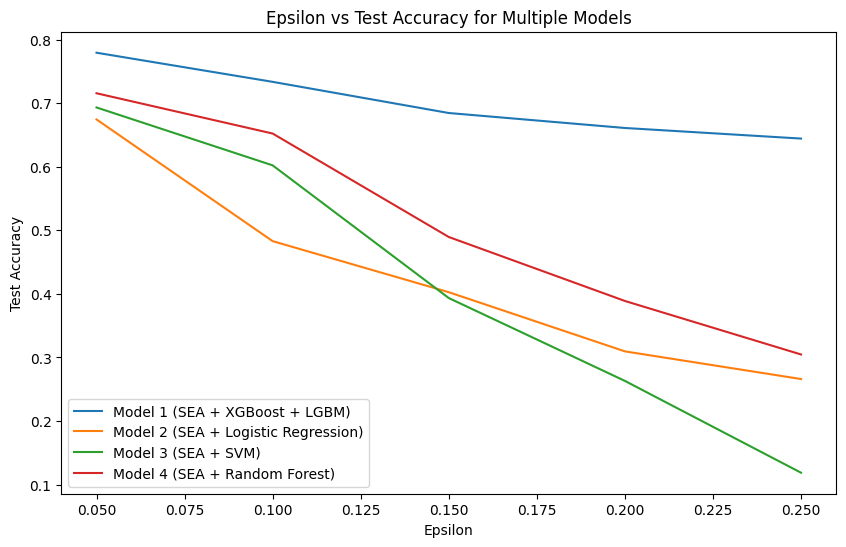

In [23]:
plt.figure(figsize=(10, 6))

# Plotting test accuracies for each model
plt.plot(epsilons, model1_test_acc, label='Model 1 (SEA + XGBoost + LGBM)')
plt.plot(epsilons, model2_test_acc, label='Model 2 (SEA + Logistic Regression)')
plt.plot(epsilons, model3_test_acc, label='Model 3 (SEA + SVM)')
plt.plot(epsilons, model4_test_acc, label='Model 4 (SEA + Random Forest)')

plt.legend()
plt.xlabel('Epsilon')
plt.ylabel('Test Accuracy')
plt.title('Epsilon vs Test Accuracy for Multiple Models')
plt.show()

# Adversarial Retraining Defense

## Adversarial Retraining

In [24]:
test2 = pd.read_csv('/content/drive/MyDrive/rule_based_data/adversary_dataset.csv')
test = pd.read_csv('/content/drive/MyDrive/rule_based_data/adversary_embed.csv')


In [25]:
test2= pd.DataFrame(test['ID']).merge(test2, on='ID').reset_index(drop = True)

In [26]:
test_dataset = TestDataset(test.iloc[:,2:].values)
test_loader = torch.utils.data.DataLoader(
  test_dataset, batch_size=64, shuffle=False, num_workers=4
)

In [27]:
test2['Opcodes'] = test2['Opcodes'].apply(lambda x: str(x).replace(',',' '))
test_encs = vectorizer.transform(test2['Opcodes'])
test_encs = test_encs.toarray()
test_encs = pd.DataFrame(test_encs)

In [28]:
preds_all = []
for i in models_nn:
  model = NeuralNet(100, 9).to(device)
  model, _ = load_checkpoint(model, i)
  nn_preds = inference(test_loader, model, device)
  preds_all.append(nn_preds)
final_preds=  pd.DataFrame(np.array(preds_all).mean(axis=0))
argmax_result = final_preds.idxmax(axis=1)
y=list(test['Family']-1)


100%|██████████| 170/170 [00:02<00:00, 79.89it/s] 


In [29]:
# FGSM attack parameters
epsilon = 0.15  # Adjust this value based on your needs

# Loop through the test loader to generate adversarial examples
adversarial_preds_all = []
for z in models_nn:
  model = NeuralNet(100, 9).to(device)
  model, _ = load_checkpoint(model, z)
  for i, data_batch in enumerate(test_loader):
      inputs = data_batch["X"].to(device)

      # Choose the target label (ground truth label)
      targets = torch.tensor(y[i * 64 : (i + 1) * 64], dtype=torch.long).to(device)

      # Generate adversarial examples
      adversarial_inputs = fgsm_attack(model, inputs, targets, epsilon)
      adversarial_preds_all.append(adversarial_inputs.detach().cpu().numpy())
adversarial_preds_all_test = np.concatenate(adversarial_preds_all, axis=0)
adversarial_preds_all_test=final_adv_sample(adversarial_preds_all_test)
columns_to_add=[]
for i in range(100):
  columns_to_add.append(str(i))
df = pd.DataFrame(adversarial_preds_all_test, columns=columns_to_add)
id=test['ID']
target=test['Family']
df=pd.concat([id,target, df], axis=1)
df.head()

,ID,Family,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,01kcPWA9K2BOxQeS5Rju,1,-0.358762,1.013335,-0.038244,-1.063908,-0.202453,-0.318010,-0.307211,0.019049,...,-0.672752,-0.818681,0.428433,0.327340,0.382978,0.814443,-0.535421,-0.945707,1.106771,0.138724
1,04EjIdbPV5e1XroFOpiN,1,-0.446770,1.099413,0.066492,-0.704747,-0.168330,-0.493342,-0.260915,0.025744,...,-0.608067,-0.717677,0.273249,0.204408,0.059694,0.934833,-0.381887,-1.034596,1.111952,0.076826
2,05EeG39MTRrI6VY21DPd,1,-0.428747,1.284679,0.042415,-0.512549,0.087344,-0.586975,-0.024651,-0.094740,...,-0.714816,-0.748147,0.236206,0.176097,0.296606,1.283540,-0.601498,-0.816324,1.223577,0.118500
3,05rJTUWYAKNegBk2wE8X,1,-0.364766,1.069489,-0.034673,-0.891299,-0.255514,-0.525856,-0.421602,0.067342,...,-0.577449,-0.713292,0.209753,0.314899,0.095021,0.875967,-0.353477,-0.970523,1.188219,0.040479
4,0AnoOZDNbPXIr2MRBSCJ,1,-0.206295,1.165975,-0.235359,-0.562231,-0.045772,-0.517110,-0.145110,-0.138091,...,-0.303468,-0.097888,-0.080081,-0.096642,0.314443,1.702823,-0.444026,-0.786999,1.008802,0.422757


In [30]:
orig_test=pd.read_csv('/content/drive/MyDrive/data/result_embed.csv')
orig_test2=pd.read_csv('/content/drive/MyDrive/data/dataset.csv')
orig_test2= pd.DataFrame(orig_test['ID']).merge(orig_test2, on='ID').reset_index(drop = True)
orig_test2['Opcodes'] = orig_test2['Opcodes'].apply(lambda x: str(x).replace(',',' '))
orig_test2.drop(columns=['Family'], inplace=True)


In [31]:
test2 = pd.read_csv('/content/drive/MyDrive/rule_based_data/adversary_dataset.csv')
test = pd.read_csv('/content/drive/MyDrive/rule_based_data/adversary_embed.csv')
test2= pd.DataFrame(test['ID']).merge(test2, on='ID').reset_index(drop = True)
test2.drop(columns=['Family'], inplace=True)
final_embed=pd.concat([orig_test, df], ignore_index=True)
final_op=pd.concat([orig_test2, test2], ignore_index=True)

In [32]:
vectorizer = TfidfVectorizer(max_features=99)
tf_encs = vectorizer.fit_transform(final_op['Opcodes'])
tf_encs = tf_encs.toarray()
Xx = pd.DataFrame(tf_encs)

In [33]:
final_embed= final_embed.reset_index(drop = True)
final_embed['Family'] = final_embed['Family'] - 1
final_embed.head()

,ID,Family,0,1,2,3,4,5,6,7,...,90,91,92,93,94,95,96,97,98,99
0,01kcPWA9K2BOxQeS5Rju,0,-0.338611,1.291727,0.118837,-1.118286,0.183966,-0.405247,-0.729886,-0.332307,...,-0.475346,-0.425257,-0.000070,0.276955,0.192112,1.176439,-0.234972,-0.730219,1.071440,-0.091770
1,04EjIdbPV5e1XroFOpiN,0,-0.428330,1.376984,0.234024,-0.627847,0.213055,-0.609343,-0.659496,-0.320076,...,-0.408290,-0.389868,-0.164271,0.207200,0.035918,1.313510,-0.123089,-0.806177,1.062548,-0.169090
2,05EeG39MTRrI6VY21DPd,0,-0.377473,1.542212,0.202506,-0.368294,0.447894,-0.722350,-0.336275,-0.411114,...,-0.553859,-0.478773,-0.139812,0.208929,0.004945,1.640448,-0.340988,-0.576668,1.164637,-0.100652
3,05rJTUWYAKNegBk2wE8X,0,-0.354789,1.304047,0.117015,-0.903091,0.150693,-0.642379,-0.896521,-0.305303,...,-0.351606,-0.341613,-0.220712,0.312799,0.046395,1.294530,-0.131182,-0.718261,1.172608,-0.229033
4,0AnoOZDNbPXIr2MRBSCJ,0,-0.175248,1.296375,-0.155661,-0.533257,0.156963,-0.595596,-0.341953,-0.253579,...,-0.324669,-0.036423,-0.272495,-0.101691,0.137479,1.847042,-0.233596,-0.768067,0.979953,0.340067


In [34]:
# warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=UserWarning, message=".*force_row_wise=true.*")
warnings.filterwarnings("ignore", category=UserWarning, message=".*force_col_wise=true.*")


i = 0
fold = 4
logloss_list, f1_list, recall_list, precision_list, accuracy_list = [], [], [], [], []
for tr_in, val_in in StratifiedKFold(n_splits=5, shuffle=True).split(final_embed, final_embed['Family']):
  x_train = final_embed.drop(['ID', 'Family'],axis=1).loc[tr_in, :]
  x_test = final_embed.drop(['ID', 'Family'],axis=1).loc[val_in, :]
  y_train = final_embed.loc[tr_in, 'Family']
  y_test = final_embed.loc[val_in, 'Family']

  xx_train = Xx.loc[tr_in, :]
  xx_test = Xx.loc[val_in, :]

  model = NeuralNet(100, 9).to(device)

  train_dataset = Dataset(
    x_train.values,
    y_train.values
  )
  train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=64, shuffle=True, num_workers=4
  )

  valid_dataset = Dataset(
    x_test.values,
    y_test.values
  )

  valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=64, shuffle=False, num_workers=4
  )
  optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

  lgbm = LGBMClassifier(n_jobs=-1, silent =True)
  xgb = XGBClassifier(n_jobs=-1, verbosity=0)
  logistic_reg = LogisticRegression(max_iter=100)
  svm_classifier = SVC(probability=True)
  random_forest = RandomForestClassifier(n_jobs=-1)

  lgbm.fit(xx_train.values, y_train.values)
  xgb.fit(xx_train.values, y_train.values)
  logistic_reg.fit(xx_train.values, y_train.values)
  svm_classifier.fit(xx_train.values, y_train.values)
  random_forest.fit(xx_train.values, y_train.values)

  pickle.dump(lgbm, open(f'/content/drive/MyDrive/rule_based_models/rule_models_lgbm/rule_lgbm_fold{i}.b5', 'wb'))
  pickle.dump(xgb, open(f'/content/drive/MyDrive/rule_based_models/rule_models_xgb/rule_xgb_fold{i}.b5', 'wb'))
  pickle.dump(logistic_reg, open(f'/content/drive/MyDrive/rule_based_models/rule_models_log/rule_logistic_reg_fold{i}.b5', 'wb'))
  pickle.dump(svm_classifier, open(f'/content/drive/MyDrive/rule_based_models/rule_models_svm/rule_svm_fold{i}.b5', 'wb'))
  pickle.dump(random_forest, open(f'/content/drive/MyDrive/rule_based_models/rule_models_rf/rule_random_forest_fold{i}.b5', 'wb'))


  best_logloss = 10
  for epoch in range(epochs):
      train_model(train_loader, model, optimizer, device=device)

      predictions, valid_targets = evaluate_model(
        valid_loader, model, device=device
      )

      lgbm_preds = lgbm.predict_proba(xx_test.values)
      xgb_preds = xgb.predict_proba(xx_test.values)

      predictions = (np.array(predictions) * 0.33 + lgbm_preds * 0.33 + xgb_preds * 0.33)

      logloss = metrics.log_loss(valid_targets, predictions)
      f1 = metrics.f1_score(valid_targets, np.array(predictions).argmax(axis=1), average='micro')
      recall = metrics.recall_score(valid_targets, np.array(predictions).argmax(axis=1), average='micro')
      precision = metrics.precision_score(valid_targets, np.array(predictions).argmax(axis=1), average='micro')
      accuracy = metrics.accuracy_score(valid_targets, np.array(predictions).argmax(axis=1))

      logloss_list.append(logloss)
      f1_list.append(f1)
      recall_list.append(recall)
      precision_list.append(precision)
      accuracy_list.append(accuracy)

      print(
        f"Epoch={epoch} \nValidation: = Logloss: {round(logloss*100,3)} F1: {round(f1*100,3)} Recall: {round(recall*100,3)} Precision: {round(precision*100,3)} Accuracy: {round(accuracy*100,3)}"
      )
      if logloss < best_logloss:
        save_checkpoint(model, optimizer, f'/content/drive/MyDrive/rule_based_models/rule_models_nn/rule_model_fold{i}_{epoch}.pth')
        best_logloss = logloss
  i += 1

[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014203 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23683
[LightGBM] [Info] Number of data points in the train set: 17388, number of used features: 97
[LightGBM] [Info] Start training from score -1.953589
[LightGBM] [Info] Start training from score -1.478274
[LightGBM] [Info] Start training from score -1.306730
[LightGBM] [Info] Start training from score -3.130217
[LightGBM] [Info] Start training from score -5.558843
[LightGBM] [Info] Start training from score -2.671793
[LightGBM] [Info] Start training from score -3.306766
[LightGBM] [Info] Start training from score -2.180288
[LightGBM] [Info] Start training from score -2.373354
[LightGBM] [Warning] No further splits with positive gain, best ga

100%|██████████| 68/68 [00:01<00:00, 55.06it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=0 
Validation: = Logloss: 12.001 F1: 99.011 Recall: 99.011 Precision: 99.011 Accuracy: 99.011


100%|██████████| 68/68 [00:01<00:00, 56.72it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=1 
Validation: = Logloss: 11.536 F1: 99.034 Recall: 99.034 Precision: 99.034 Accuracy: 99.034


100%|██████████| 68/68 [00:01<00:00, 56.15it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=2 
Validation: = Logloss: 10.122 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 34.18it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=3 
Validation: = Logloss: 10.023 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 48.63it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=4 
Validation: = Logloss: 9.253 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 54.25it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=5 
Validation: = Logloss: 9.32 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 57.10it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=6 
Validation: = Logloss: 8.865 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 34.80it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=7 
Validation: = Logloss: 8.666 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 55.62it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=8 
Validation: = Logloss: 8.557 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 58.38it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=9 
Validation: = Logloss: 8.46 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 34.85it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=10 
Validation: = Logloss: 8.702 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 55.43it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=11 
Validation: = Logloss: 8.369 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 59.40it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=12 
Validation: = Logloss: 8.532 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 38.71it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=13 
Validation: = Logloss: 8.204 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 37.41it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=14 
Validation: = Logloss: 8.254 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 58.37it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=15 
Validation: = Logloss: 8.031 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 44.15it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=16 
Validation: = Logloss: 7.97 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 49.08it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=17 
Validation: = Logloss: 8.375 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 50.50it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=18 
Validation: = Logloss: 7.98 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 58.04it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=19 
Validation: = Logloss: 7.927 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 36.60it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=20 
Validation: = Logloss: 7.853 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 57.63it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=21 
Validation: = Logloss: 8.327 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 59.63it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=22 
Validation: = Logloss: 7.834 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:02<00:00, 33.78it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=23 
Validation: = Logloss: 7.943 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:02<00:00, 27.70it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=24 
Validation: = Logloss: 7.825 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 57.64it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=25 
Validation: = Logloss: 7.684 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 59.20it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=26 
Validation: = Logloss: 7.738 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 39.35it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=27 
Validation: = Logloss: 8.143 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 59.61it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=28 
Validation: = Logloss: 7.762 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 58.18it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=29 
Validation: = Logloss: 7.696 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 38.37it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=30 
Validation: = Logloss: 7.773 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 56.44it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=31 
Validation: = Logloss: 7.78 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 57.55it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=32 
Validation: = Logloss: 7.673 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 36.19it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=33 
Validation: = Logloss: 7.997 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 35.81it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=34 
Validation: = Logloss: 7.61 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 58.78it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=35 
Validation: = Logloss: 7.657 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 49.00it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=36 
Validation: = Logloss: 7.623 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 41.22it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=37 
Validation: = Logloss: 7.683 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 57.81it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=38 
Validation: = Logloss: 7.802 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 55.54it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=39 
Validation: = Logloss: 7.633 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 37.91it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=40 
Validation: = Logloss: 7.578 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 56.14it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=41 
Validation: = Logloss: 7.642 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 54.53it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=42 
Validation: = Logloss: 7.601 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 36.53it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=43 
Validation: = Logloss: 7.572 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 54.43it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=44 
Validation: = Logloss: 7.581 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 55.78it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=45 
Validation: = Logloss: 7.559 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 37.00it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=46 
Validation: = Logloss: 7.716 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 58.03it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=47 
Validation: = Logloss: 7.729 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 56.46it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=48 
Validation: = Logloss: 7.552 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057


100%|██████████| 68/68 [00:01<00:00, 52.00it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=49 
Validation: = Logloss: 7.845 F1: 99.057 Recall: 99.057 Precision: 99.057 Accuracy: 99.057
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 23685
[LightGBM] [Info] Number of data points in the train set: 17389, number of used features: 97
[LightGBM] [Info] Start training from score -1.953646
[LightGBM] [Info] Start training from score -1.478332
[LightGBM] [Info] Start training from score -1.306787
[LightGBM] [Info] Start training from score -3.130275
[LightGBM] [Info] Start training from score -5.544085
[LightGBM] [Info] Start training from score -2.672683
[LightGBM] [Info] Start training from score -3.306823
[LightGBM] [Info] Start training from score -2.180346
[LightGBM] [Info] Start training from

100%|██████████| 68/68 [00:01<00:00, 53.58it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=0 
Validation: = Logloss: 13.405 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 55.04it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=1 
Validation: = Logloss: 13.096 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 37.36it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=2 
Validation: = Logloss: 12.993 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 51.33it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=3 
Validation: = Logloss: 11.796 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 54.35it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=4 
Validation: = Logloss: 11.412 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 52.51it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=5 
Validation: = Logloss: 8.041 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 36.04it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=6 
Validation: = Logloss: 7.553 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 55.45it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=7 
Validation: = Logloss: 7.378 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 55.89it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=8 
Validation: = Logloss: 7.173 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 44.31it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=9 
Validation: = Logloss: 7.067 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 40.23it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=10 
Validation: = Logloss: 6.933 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 55.83it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=11 
Validation: = Logloss: 6.983 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 56.91it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=12 
Validation: = Logloss: 7.056 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 36.14it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=13 
Validation: = Logloss: 6.837 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 54.88it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=14 
Validation: = Logloss: 6.809 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 57.18it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=15 
Validation: = Logloss: 6.818 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:02<00:00, 31.42it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=16 
Validation: = Logloss: 6.724 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 56.73it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=17 
Validation: = Logloss: 6.842 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 53.46it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=18 
Validation: = Logloss: 6.652 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 34.48it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=19 
Validation: = Logloss: 6.61 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 56.58it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=20 
Validation: = Logloss: 6.604 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:02<00:00, 30.98it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=21 
Validation: = Logloss: 6.614 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 54.24it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=22 
Validation: = Logloss: 6.485 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 35.59it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=23 
Validation: = Logloss: 6.72 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 57.06it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=24 
Validation: = Logloss: 6.578 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 54.40it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=25 
Validation: = Logloss: 6.512 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 47.15it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=26 
Validation: = Logloss: 6.445 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:02<00:00, 26.29it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=27 
Validation: = Logloss: 6.429 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 54.84it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=28 
Validation: = Logloss: 6.535 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 57.31it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=29 
Validation: = Logloss: 6.513 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 36.94it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=30 
Validation: = Logloss: 6.515 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 56.75it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=31 
Validation: = Logloss: 6.442 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 49.75it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=32 
Validation: = Logloss: 6.581 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 37.70it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=33 
Validation: = Logloss: 6.62 F1: 99.126 Recall: 99.126 Precision: 99.126 Accuracy: 99.126


100%|██████████| 68/68 [00:01<00:00, 49.35it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=34 
Validation: = Logloss: 6.453 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 56.01it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=35 
Validation: = Logloss: 6.629 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 56.57it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=36 
Validation: = Logloss: 6.629 F1: 99.126 Recall: 99.126 Precision: 99.126 Accuracy: 99.126


100%|██████████| 68/68 [00:01<00:00, 37.58it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=37 
Validation: = Logloss: 6.673 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 55.37it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=38 
Validation: = Logloss: 6.603 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 56.79it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=39 
Validation: = Logloss: 6.821 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 36.59it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=40 
Validation: = Logloss: 6.637 F1: 99.126 Recall: 99.126 Precision: 99.126 Accuracy: 99.126


100%|██████████| 68/68 [00:01<00:00, 55.55it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=41 
Validation: = Logloss: 6.573 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 58.31it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=42 
Validation: = Logloss: 6.74 F1: 99.172 Recall: 99.172 Precision: 99.172 Accuracy: 99.172


100%|██████████| 68/68 [00:01<00:00, 36.00it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=43 
Validation: = Logloss: 6.554 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 57.93it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=44 
Validation: = Logloss: 6.591 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 57.44it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=45 
Validation: = Logloss: 6.593 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 43.47it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=46 
Validation: = Logloss: 6.579 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 43.83it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=47 
Validation: = Logloss: 6.566 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 56.59it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=48 
Validation: = Logloss: 6.602 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149


100%|██████████| 68/68 [00:01<00:00, 56.22it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=49 
Validation: = Logloss: 6.562 F1: 99.149 Recall: 99.149 Precision: 99.149 Accuracy: 99.149
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23682
[LightGBM] [Info] Number of data points in the train set: 17389, number of used features: 97
[LightGBM] [Info] Start training from score -1.953240
[LightGBM] [Info] Start training from score -1.478584
[LightGBM] [Info] Start training from score -1.306575
[LightGBM] [Info] Start training from score -3.130275
[LightGBM] [Info] Start training from score -5.558900
[LightGBM] [Info] Start training from score -2.672683
[LightGBM] [Info] Start training from score -3.306823
[LightGBM] [Info] Start tra

100%|██████████| 68/68 [00:01<00:00, 54.26it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=0 
Validation: = Logloss: 13.491 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 56.78it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=1 
Validation: = Logloss: 13.219 F1: 99.448 Recall: 99.448 Precision: 99.448 Accuracy: 99.448


100%|██████████| 68/68 [00:01<00:00, 35.79it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=2 
Validation: = Logloss: 12.099 F1: 99.448 Recall: 99.448 Precision: 99.448 Accuracy: 99.448


100%|██████████| 68/68 [00:01<00:00, 53.26it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=3 
Validation: = Logloss: 11.137 F1: 99.448 Recall: 99.448 Precision: 99.448 Accuracy: 99.448


100%|██████████| 68/68 [00:02<00:00, 33.65it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=4 
Validation: = Logloss: 8.406 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 55.61it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=5 
Validation: = Logloss: 7.868 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:02<00:00, 33.67it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=6 
Validation: = Logloss: 7.864 F1: 99.448 Recall: 99.448 Precision: 99.448 Accuracy: 99.448


100%|██████████| 68/68 [00:01<00:00, 54.81it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=7 
Validation: = Logloss: 7.447 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 56.65it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=8 
Validation: = Logloss: 7.252 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 37.38it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=9 
Validation: = Logloss: 7.143 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 50.57it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=10 
Validation: = Logloss: 7.074 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 53.76it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=11 
Validation: = Logloss: 7.013 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 55.55it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=12 
Validation: = Logloss: 7.078 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 36.30it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=13 
Validation: = Logloss: 7.001 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 53.39it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=14 
Validation: = Logloss: 7.018 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 55.75it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=15 
Validation: = Logloss: 7.174 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 35.54it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=16 
Validation: = Logloss: 6.833 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 56.60it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=17 
Validation: = Logloss: 6.819 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 34.78it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=18 
Validation: = Logloss: 6.831 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:02<00:00, 30.07it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=19 
Validation: = Logloss: 7.058 F1: 99.448 Recall: 99.448 Precision: 99.448 Accuracy: 99.448


100%|██████████| 68/68 [00:01<00:00, 36.16it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=20 
Validation: = Logloss: 6.805 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 53.54it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=21 
Validation: = Logloss: 6.745 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 54.70it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=22 
Validation: = Logloss: 6.759 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 56.99it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=23 
Validation: = Logloss: 6.633 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 34.48it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=24 
Validation: = Logloss: 6.592 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 54.49it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=25 
Validation: = Logloss: 6.576 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 55.05it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=26 
Validation: = Logloss: 6.663 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 36.39it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=27 
Validation: = Logloss: 6.612 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 55.88it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=28 
Validation: = Logloss: 6.701 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 54.05it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=29 
Validation: = Logloss: 6.744 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 36.09it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=30 
Validation: = Logloss: 6.526 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 42.38it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=31 
Validation: = Logloss: 6.508 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 53.71it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=32 
Validation: = Logloss: 6.516 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 54.70it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=33 
Validation: = Logloss: 6.517 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 34.51it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=34 
Validation: = Logloss: 5.482 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 55.66it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=35 
Validation: = Logloss: 5.388 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 54.38it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=36 
Validation: = Logloss: 5.509 F1: 99.494 Recall: 99.494 Precision: 99.494 Accuracy: 99.494


100%|██████████| 68/68 [00:01<00:00, 36.53it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=37 
Validation: = Logloss: 5.339 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 55.78it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=38 
Validation: = Logloss: 5.431 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 52.24it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=39 
Validation: = Logloss: 5.322 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 52.76it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=40 
Validation: = Logloss: 5.288 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 36.17it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=41 
Validation: = Logloss: 5.393 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 54.62it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=42 
Validation: = Logloss: 5.308 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 55.68it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=43 
Validation: = Logloss: 5.295 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 35.47it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=44 
Validation: = Logloss: 5.306 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 54.67it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=45 
Validation: = Logloss: 5.292 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 54.18it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=46 
Validation: = Logloss: 5.198 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 40.08it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=47 
Validation: = Logloss: 5.243 F1: 99.494 Recall: 99.494 Precision: 99.494 Accuracy: 99.494


100%|██████████| 68/68 [00:01<00:00, 43.79it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=48 
Validation: = Logloss: 5.727 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471


100%|██████████| 68/68 [00:01<00:00, 53.38it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=49 
Validation: = Logloss: 5.298 F1: 99.471 Recall: 99.471 Precision: 99.471 Accuracy: 99.471
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012408 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23690
[LightGBM] [Info] Number of data points in the train set: 17389, number of used features: 97
[LightGBM] [Info] Start training from score -1.953240
[LightGBM] [Info] Start training from score -1.478332
[LightGBM] [Info] Start training from score -1.306787
[LightGBM] [Info] Start training from score -3.130275
[LightGBM] [Info] Start training from score -5.558900
[LightGBM] [Info] Start training from score -2.671851
[LightGBM] [Info] Start training from score -3.308395
[LightGBM] [Info] Start tra

100%|██████████| 68/68 [00:01<00:00, 36.90it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=0 
Validation: = Logloss: 14.196 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 34.27it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=1 
Validation: = Logloss: 11.015 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 53.47it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=2 
Validation: = Logloss: 6.913 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 54.41it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=3 
Validation: = Logloss: 6.37 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 34.87it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=4 
Validation: = Logloss: 6.069 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 54.49it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=5 
Validation: = Logloss: 6.176 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 56.70it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=6 
Validation: = Logloss: 6.004 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 54.89it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=7 
Validation: = Logloss: 5.881 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 36.03it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=8 
Validation: = Logloss: 5.876 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 53.06it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=9 
Validation: = Logloss: 5.793 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 52.26it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=10 
Validation: = Logloss: 6.126 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 35.67it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=11 
Validation: = Logloss: 5.861 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 54.97it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=12 
Validation: = Logloss: 5.732 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 55.67it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=13 
Validation: = Logloss: 5.587 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 34.71it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=14 
Validation: = Logloss: 5.718 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:03<00:00, 22.63it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=15 
Validation: = Logloss: 5.601 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:02<00:00, 30.97it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=16 
Validation: = Logloss: 5.562 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 54.98it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=17 
Validation: = Logloss: 5.702 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 35.25it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=18 
Validation: = Logloss: 5.58 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 52.05it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=19 
Validation: = Logloss: 5.447 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 55.10it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=20 
Validation: = Logloss: 5.486 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 54.07it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=21 
Validation: = Logloss: 5.376 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:02<00:00, 33.21it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=22 
Validation: = Logloss: 5.291 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 54.59it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=23 
Validation: = Logloss: 5.28 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 53.52it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=24 
Validation: = Logloss: 5.354 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 35.63it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=25 
Validation: = Logloss: 5.234 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 35.27it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=26 
Validation: = Logloss: 5.227 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 53.82it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=27 
Validation: = Logloss: 5.235 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 55.01it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=28 
Validation: = Logloss: 5.275 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 34.39it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=29 
Validation: = Logloss: 5.18 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 54.18it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=30 
Validation: = Logloss: 5.232 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 54.33it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=31 
Validation: = Logloss: 5.264 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 48.83it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=32 
Validation: = Logloss: 5.136 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 35.57it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=33 
Validation: = Logloss: 5.527 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 54.35it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=34 
Validation: = Logloss: 5.084 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 54.66it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=35 
Validation: = Logloss: 5.114 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 35.58it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=36 
Validation: = Logloss: 5.165 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 55.18it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=37 
Validation: = Logloss: 5.431 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 55.42it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=38 
Validation: = Logloss: 5.18 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 35.85it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=39 
Validation: = Logloss: 5.237 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 52.37it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=40 
Validation: = Logloss: 5.241 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 54.80it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=41 
Validation: = Logloss: 5.175 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 49.96it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=42 
Validation: = Logloss: 5.2 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:02<00:00, 23.55it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=43 
Validation: = Logloss: 5.137 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 54.40it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=44 
Validation: = Logloss: 5.068 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 54.98it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=45 
Validation: = Logloss: 5.024 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 41.57it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=46 
Validation: = Logloss: 5.153 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 35.59it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=47 
Validation: = Logloss: 5.189 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 54.33it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=48 
Validation: = Logloss: 5.112 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 53.99it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=49 
Validation: = Logloss: 5.041 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013122 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 23688
[LightGBM] [Info] Number of data points in the train set: 17389, number of used features: 97
[LightGBM] [Info] Start training from score -1.953240
[LightGBM] [Info] Start training from score -1.478332
[LightGBM] [Info] Start training from score -1.306787
[LightGBM] [Info] Start training from score -3.130275
[LightGBM] [Info] Start training from score -5.558900
[LightGBM] [Info] Start training from score -2.671851
[LightGBM] [Info] Start training from score -3.306823
[LightGBM] [Info] Start tra

100%|██████████| 68/68 [00:01<00:00, 50.10it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=0 
Validation: = Logloss: 10.266 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 53.29it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=1 
Validation: = Logloss: 9.643 F1: 99.287 Recall: 99.287 Precision: 99.287 Accuracy: 99.287


100%|██████████| 68/68 [00:01<00:00, 39.48it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=2 
Validation: = Logloss: 9.522 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 39.11it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=3 
Validation: = Logloss: 8.273 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 49.84it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=4 
Validation: = Logloss: 8.312 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 55.10it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=5 
Validation: = Logloss: 8.169 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:02<00:00, 33.00it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=6 
Validation: = Logloss: 7.468 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 56.09it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=7 
Validation: = Logloss: 7.373 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 54.56it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=8 
Validation: = Logloss: 7.234 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 35.68it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=9 
Validation: = Logloss: 7.157 F1: 99.31 Recall: 99.31 Precision: 99.31 Accuracy: 99.31


100%|██████████| 68/68 [00:01<00:00, 50.91it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=10 
Validation: = Logloss: 7.12 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 54.36it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=11 
Validation: = Logloss: 7.22 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 50.25it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=12 
Validation: = Logloss: 7.116 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:02<00:00, 32.73it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=13 
Validation: = Logloss: 7.142 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:02<00:00, 30.33it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=14 
Validation: = Logloss: 7.107 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 52.15it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=15 
Validation: = Logloss: 7.033 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 52.16it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=16 
Validation: = Logloss: 7.188 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 35.00it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=17 
Validation: = Logloss: 6.932 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 51.65it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=18 
Validation: = Logloss: 6.962 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 54.66it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=19 
Validation: = Logloss: 6.87 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 35.96it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=20 
Validation: = Logloss: 7.165 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:02<00:00, 32.89it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=21 
Validation: = Logloss: 6.83 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 50.10it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=22 
Validation: = Logloss: 6.766 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 50.99it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=23 
Validation: = Logloss: 6.783 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 52.41it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=24 
Validation: = Logloss: 6.649 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 34.93it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=25 
Validation: = Logloss: 6.993 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 52.65it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=26 
Validation: = Logloss: 6.716 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 52.39it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=27 
Validation: = Logloss: 6.7 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 38.95it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=28 
Validation: = Logloss: 6.811 F1: 99.425 Recall: 99.425 Precision: 99.425 Accuracy: 99.425


100%|██████████| 68/68 [00:01<00:00, 37.95it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=29 
Validation: = Logloss: 6.596 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 54.52it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=30 
Validation: = Logloss: 7.198 F1: 99.402 Recall: 99.402 Precision: 99.402 Accuracy: 99.402


100%|██████████| 68/68 [00:01<00:00, 54.40it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=31 
Validation: = Logloss: 6.585 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:02<00:00, 33.04it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=32 
Validation: = Logloss: 6.609 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 54.14it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=33 
Validation: = Logloss: 6.568 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 40.08it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=34 
Validation: = Logloss: 6.598 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 41.11it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=35 
Validation: = Logloss: 6.601 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 39.30it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=36 
Validation: = Logloss: 6.671 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 53.40it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=37 
Validation: = Logloss: 6.573 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 53.35it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=38 
Validation: = Logloss: 6.635 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 35.71it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=39 
Validation: = Logloss: 6.555 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 52.50it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=40 
Validation: = Logloss: 6.571 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 52.90it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=41 
Validation: = Logloss: 6.57 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 38.05it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=42 
Validation: = Logloss: 6.653 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


100%|██████████| 68/68 [00:01<00:00, 41.77it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=43 
Validation: = Logloss: 6.568 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 53.42it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=44 
Validation: = Logloss: 6.566 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 50.90it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=45 
Validation: = Logloss: 6.646 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:02<00:00, 31.30it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=46 
Validation: = Logloss: 6.498 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 50.75it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=47 
Validation: = Logloss: 6.515 F1: 99.356 Recall: 99.356 Precision: 99.356 Accuracy: 99.356


100%|██████████| 68/68 [00:01<00:00, 54.74it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=48 
Validation: = Logloss: 6.548 F1: 99.379 Recall: 99.379 Precision: 99.379 Accuracy: 99.379


100%|██████████| 68/68 [00:01<00:00, 35.69it/s]


[LightGBM] [Warning] Unknown parameter: silent
Epoch=49 
Validation: = Logloss: 6.646 F1: 99.333 Recall: 99.333 Precision: 99.333 Accuracy: 99.333


## Testing the Defense

In [35]:
test_dataset = TestDataset(final_embed.iloc[:,2:].values)
test_loader = torch.utils.data.DataLoader(
  test_dataset, batch_size=64, shuffle=False, num_workers=4
)

In [36]:
final_op['Opcodes'] = final_op['Opcodes'].apply(lambda x: str(x).replace(',',' '))
test_encs = vectorizer.transform(final_op['Opcodes'])
test_encs = test_encs.toarray()

test_encs = pd.DataFrame(test_encs)

In [37]:
models_nn = [
             '/content/drive/MyDrive/rule_based_models/rule_models_nn/rule_model_fold0_48.pth',
             '/content/drive/MyDrive/rule_based_models/rule_models_nn/rule_model_fold1_27.pth',
             '/content/drive/MyDrive/rule_based_models/rule_models_nn/rule_model_fold2_46.pth',
             '/content/drive/MyDrive/rule_based_models/rule_models_nn/rule_model_fold3_45.pth',
             '/content/drive/MyDrive/rule_based_models/rule_models_nn/rule_model_fold4_46.pth'
]
models_xgb = [
              '/content/drive/MyDrive/rule_based_models/rule_models_xgb/rule_xgb_fold0.b5',
              '/content/drive/MyDrive/rule_based_models/rule_models_xgb/rule_xgb_fold1.b5',
              '/content/drive/MyDrive/rule_based_models/rule_models_xgb/rule_xgb_fold2.b5',
              '/content/drive/MyDrive/rule_based_models/rule_models_xgb/rule_xgb_fold3.b5',
              '/content/drive/MyDrive/rule_based_models/rule_models_xgb/rule_xgb_fold4.b5'
]

models_lgbm = [
               '/content/drive/MyDrive/rule_based_models/rule_models_lgbm/rule_lgbm_fold0.b5',
               '/content/drive/MyDrive/rule_based_models/rule_models_lgbm/rule_lgbm_fold1.b5',
               '/content/drive/MyDrive/rule_based_models/rule_models_lgbm/rule_lgbm_fold2.b5',
               '/content/drive/MyDrive/rule_based_models/rule_models_lgbm/rule_lgbm_fold3.b5',
               '/content/drive/MyDrive/rule_based_models/rule_models_lgbm/rule_lgbm_fold4.b5'
]

models_log=[
               '/content/drive/MyDrive/rule_based_models/rule_models_log/rule_logistic_reg_fold0.b5',
               '/content/drive/MyDrive/rule_based_models/rule_models_log/rule_logistic_reg_fold1.b5',
               '/content/drive/MyDrive/rule_based_models/rule_models_log/rule_logistic_reg_fold2.b5',
               '/content/drive/MyDrive/rule_based_models/rule_models_log/rule_logistic_reg_fold3.b5',
               '/content/drive/MyDrive/rule_based_models/rule_models_log/rule_logistic_reg_fold4.b5',
]

models_svm=[
               '/content/drive/MyDrive/rule_based_models/rule_models_svm/rule_svm_fold0.b5',
               '/content/drive/MyDrive/rule_based_models/rule_models_svm/rule_svm_fold1.b5',
               '/content/drive/MyDrive/rule_based_models/rule_models_svm/rule_svm_fold2.b5',
               '/content/drive/MyDrive/rule_based_models/rule_models_svm/rule_svm_fold3.b5',
               '/content/drive/MyDrive/rule_based_models/rule_models_svm/rule_svm_fold4.b5'
]

models_rf=[
               '/content/drive/MyDrive/rule_based_models/rule_models_rf/rule_random_forest_fold0.b5',
               '/content/drive/MyDrive/rule_based_models/rule_models_rf/rule_random_forest_fold1.b5',
               '/content/drive/MyDrive/rule_based_models/rule_models_rf/rule_random_forest_fold2.b5',
               '/content/drive/MyDrive/rule_based_models/rule_models_rf/rule_random_forest_fold3.b5',
               '/content/drive/MyDrive/rule_based_models/rule_models_rf/rule_random_forest_fold4.b5'
]

In [38]:
model1_preds_all = []
model2_preds_all = []
model3_preds_all = []
model4_preds_all = []

test_accs_new=[]

for model_nn, model_lgbm, model_xgb, model_log, model_svm, model_rf in zip(models_nn, models_lgbm, models_xgb, models_log, models_svm, models_rf):
  model = NeuralNet(100, 9).to(device)
  model, _ = load_checkpoint(model, model_nn)
  model_xgb = pickle.load(open(model_xgb, 'rb'))
  model_lgbm = pickle.load(open(model_lgbm, 'rb'))
  model_log = pickle.load(open(model_log, 'rb'))
  model_svm = pickle.load(open(model_svm, 'rb'))
  model_rf = pickle.load(open(model_rf, 'rb'))

  nn_preds = inference(test_loader, model, device)
  lgbm_preds = model_lgbm.predict_proba(test_encs.values)
  xgb_preds = model_xgb.predict_proba(test_encs.values)
  log_preds = model_log.predict_proba(test_encs.values)
  svm_preds = model_svm.predict_proba(test_encs.values)
  rf_preds = model_rf.predict_proba(test_encs.values)

  model1_preds = np.array(nn_preds) * 0.33 + lgbm_preds * 0.33 + xgb_preds * 0.33
  model2_preds = np.array(nn_preds) * 0.50 + log_preds * 0.50
  model3_preds=np.array(nn_preds) * 0.50 + svm_preds * 0.50
  model4_preds = np.array(nn_preds) * 0.50 + rf_preds * 0.50

  model1_preds_all.append(model1_preds)
  model2_preds_all.append(model2_preds)
  model3_preds_all.append(model3_preds)
  model4_preds_all.append(model4_preds)

model1_final_preds=  pd.DataFrame(np.array(model1_preds_all).mean(axis=0))
model1_final_preds = model1_final_preds.idxmax(axis=1)
model1_final_test_acc = (get_final_test_acc(final_embed['Family'],model1_final_preds))/len(model1_final_preds)
test_accs_new.append(model1_final_test_acc)
print("\n\nTest Accuracy for Model 1 (SEA + XGBoost + LGBM) before Defense = ",test_accs[0])
print("Test Accuracy for Model 1 (SEA + XGBoost + LGBM) after Defense = ",model1_final_test_acc)


model2_final_preds=  pd.DataFrame(np.array(model2_preds_all).mean(axis=0))
model2_final_preds = model2_final_preds.idxmax(axis=1)
model2_final_test_acc = (get_final_test_acc(final_embed['Family'],model2_final_preds))/len(model2_final_preds)
test_accs_new.append(model2_final_test_acc)
print("\n\nTest Accuracy for Model 2 (SEA + Logistic Regression) before Defense = ",test_accs[1])
print("Test Accuracy for Model 2 (SEA + Logistic Regression) after Defense = ",model2_final_test_acc)

model3_final_preds=  pd.DataFrame(np.array(model3_preds_all).mean(axis=0))
model3_final_preds = model3_final_preds.idxmax(axis=1)
model3_final_test_acc = (get_final_test_acc(final_embed['Family'],model3_final_preds))/len(model3_final_preds)
test_accs_new.append(model3_final_test_acc)
print("\n\nTest Accuracy for Model 3 (SEA + SVM) before Defense = ",test_accs[1])
print("Test Accuracy for Model 3 (SEA + SVM) after Defense = ",model3_final_test_acc)


model4_final_preds=  pd.DataFrame(np.array(model4_preds_all).mean(axis=0))
model4_final_preds = model4_final_preds.idxmax(axis=1)
model4_final_test_acc = (get_final_test_acc(final_embed['Family'],model4_final_preds))/len(model4_final_preds)
test_accs_new.append(model4_final_test_acc)
print("\n\nTest Accuracy for Model 4 (SEA + Random Forest) before Defense = ",test_accs[3])
print("Test Accuracy for Model 4 (SEA + Random Forest) after Defense = ",model4_final_test_acc)



100%|██████████| 340/340 [00:10<00:00, 31.31it/s]


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 340/340 [00:03<00:00, 85.55it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 340/340 [00:03<00:00, 88.61it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 340/340 [00:03<00:00, 96.19it/s] 


[LightGBM] [Warning] Unknown parameter: silent


100%|██████████| 340/340 [00:04<00:00, 69.50it/s]


[LightGBM] [Warning] Unknown parameter: silent


Test Accuracy for Model 1 (SEA + XGBoost + LGBM) before Defense =  0.7794442399705558
Test Accuracy for Model 1 (SEA + XGBoost + LGBM) after Defense =  0.9978836952521163


Test Accuracy for Model 2 (SEA + Logistic Regression) before Defense =  0.6744571218255428
Test Accuracy for Model 2 (SEA + Logistic Regression) after Defense =  0.9567537725432462


Test Accuracy for Model 3 (SEA + SVM) before Defense =  0.6744571218255428
Test Accuracy for Model 3 (SEA + SVM) after Defense =  0.9773647405226352


Test Accuracy for Model 4 (SEA + Random Forest) before Defense =  0.715679057784321
Test Accuracy for Model 4 (SEA + Random Forest) after Defense =  0.985875966139124


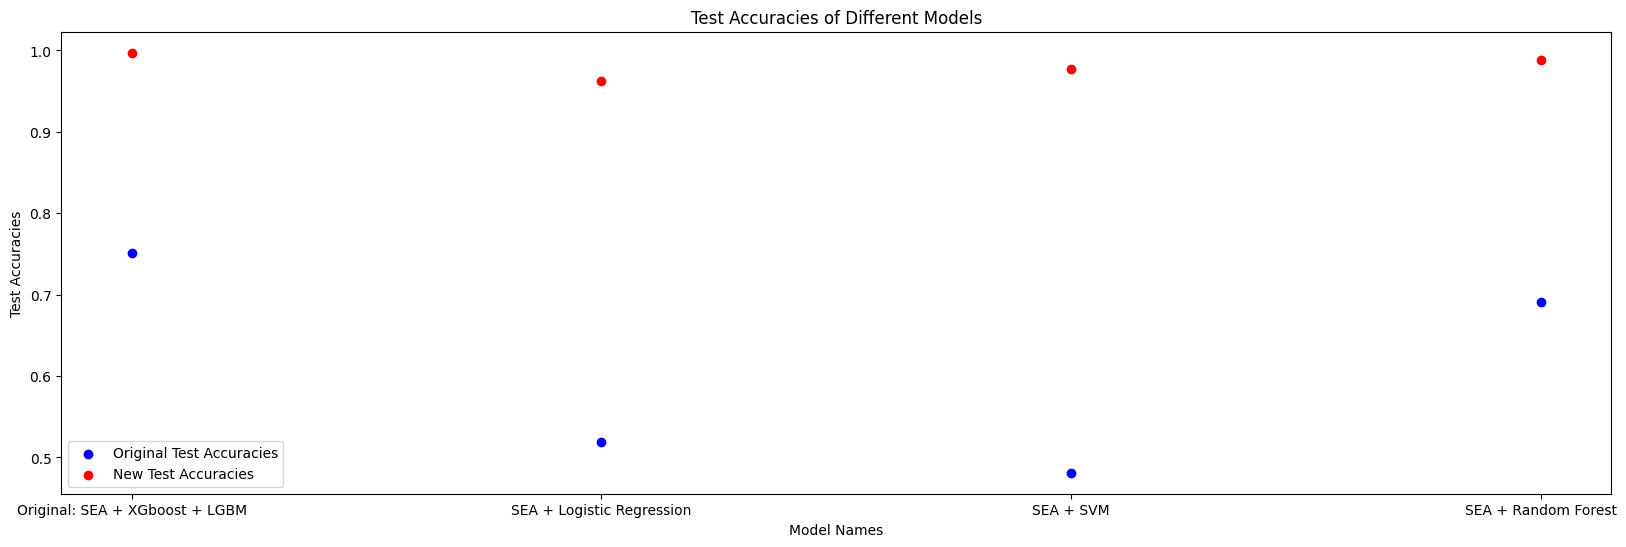

In [ ]:
model_names=['Original: SEA + XGboost + LGBM','SEA + Logistic Regression','SEA + SVM','SEA + Random Forest']
test_accs=[model1_test_acc[2],model2_test_acc[2],model3_test_acc[2],model4_test_acc[2]]
# Set the figure size
plt.figure(figsize=(20, 6))

# Create the original scatter plot
plt.scatter(model_names, test_accs, color='blue', label='Original Test Accuracies')

# Add the new data to the plot
plt.scatter(model_names, test_accs_new, color='red', label='New Test Accuracies')

# Add labels and title
plt.xlabel('Model Names')
plt.ylabel('Test Accuracies')
plt.title('Test Accuracies of Different Models')

# Add a legend to differentiate between the original and new data
plt.legend()

# Show the plot
plt.show()